In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

from lsst.daf.butler import Butler
from lsst.pipe.base import Instrument
import lsst.afw.cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, FIELD_ANGLE


# Code to get QE information from the LSSTCam Instrument

In [3]:
_ = Butler.makeRepo("lsstcam_test_repo")

butler = Butler("lsstcam_test_repo", writeable=True)
instr = Instrument.from_string("lsst.obs.lsst.LsstCam")
instr.register(butler.registry)
instr.writeCuratedCalibrations(butler)

camera = butler.get("camera", instrument="LSSTCam", collections=...)

In [4]:
!ls lsstcam_test_repo/LSSTCam/calib/curated/*/transmission_sensor/*R11_S11*

lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_R11_S11_LSSTCam_calib_curated_19700101T000000Z.fits


In [5]:
hdu = fits.open('lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_R11_S11_LSSTCam_calib_curated_19700101T000000Z.fits')
hdu.info()

Filename: lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_R11_S11_LSSTCam_calib_curated_19700101T000000Z.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ARCHIVE_INDEX    1 BinTableHDU     41   1R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  2  SpatiallyConstantTransmissionCurve    1 BinTableHDU     30   1R x 4C   [1D, 1D, 1QD(7), 1QD(7)]   


In [6]:
print(hdu[1].data)

[(1, 1, 0, 0, 1, 'SpatiallyConstantTransmissionCurve', 'lsst.afw.image')]


In [7]:
print(hdu[2].data.columns)
print(hdu[2].data)
print(hdu[2].data['throughput'])
print(hdu[2].data['wavelengths'])

ColDefs(
    name = 'throughputAtMin'; format = '1D'
    name = 'throughputAtMax'; format = '1D'
    name = 'throughput'; format = '1QD(7)'
    name = 'wavelengths'; format = '1QD(7)'; unit = 'angstrom'
)
[(0., 0., [0, 0, 0, 0, 0, 0, 0], [3499, 4500, 5000, 6199, 7500, 8699, 9999])]
[array([0.72908479, 0.86512512, 0.90641272, 0.97010344, 0.96969086,
        0.8986153 , 0.26638383])                                   ]
[array([3499.81982422, 4500.35009766, 5000.18017578, 6199.97021484,
        7500.21972656, 8699.66992188, 9999.75976562])              ]


In [8]:
hduc = fits.open('lsstcam_test_repo/LSSTCam/calib/unbounded/camera/camera_LSSTCam_LSSTCam_calib_unbounded.fits')
hduc.info()

Filename: lsstcam_test_repo/LSSTCam/calib/unbounded/camera/camera_LSSTCam_LSSTCam_calib_unbounded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ARCHIVE_INDEX    1 BinTableHDU     41   824R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  2  Camera        1 BinTableHDU     17   205R x 1C   [1J]   
  3  Detector      1 BinTableHDU    115   205R x 22C   [1QA(7), 1J, 1J, 1QA(14), 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1QE(0), 1QA(6), 1J]   
  4  TransformMap    1 BinTableHDU     33   411R x 5C   [1QA(10), 1QA(7), 1QA(10), 1QA(7), 1J]   
  5  TransformPoint2ToPoint2    1 BinTableHDU     17   411R x 1C   [1QB(3288)]   
  6  Detector      1 BinTableHDU    200   3216R x 38C   [3X, 1QA(3), 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1J, 1QD(2), 1QA(12), 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1D, 1D, 1QA(2)]   
  7  Camera        1 BinTableHDU     25   1R x 3C   [1QA(7

In [9]:
def get_qe_lsstcam(det_num,camera,bulter):

    detector = camera[det_num]

    qe = butler.get("transmission_sensor", detector=det_num, instrument="LSSTCam", collections=...)

    lambdas = np.linspace(
        qe.getWavelengthBounds()[0],
        qe.getWavelengthBounds()[1],
        1000)

    cent = detector.getCenter(lsst.afw.cameraGeom.FOCAL_PLANE)

    qe_values = qe.sampleAt(position=cent, wavelengths=lambdas)
    return lambdas/10.,qe_values

In [10]:
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_ptype = {i: det.getPhysicalType() for i, det in enumerate(camera)}

def get_allrtmtype():
    rtm_type = {'R00':'corner','R01':'itl','R02':'itl','R03':'itl','R04':'corner',
                'R10':'itl','R11':'e2v','R12':'e2v','R13':'e2v','R14':'e2v',
                'R20':'itl','R21':'e2v','R22':'e2v','R23':'e2v','R24':'e2v',
                'R30':'e2v','R31':'e2v','R32':'e2v','R33':'e2v','R34':'e2v',
                'R40':'corner','R41':'itl','R42':'itl','R43':'itl','R44':'corner'}
    return rtm_type

# can use det.getPhysicalType()  to return E2V,ITL,ITL_G,ITL_WF

rtmtypes = get_allrtmtype()

In [11]:
adet = camera[29]
print(adet.getName())
print(adet.getPhysicalType())
print(adet.getId())
print(f"{adet.getCenter(FIELD_ANGLE) = } (radians)")
print(f"{adet.getCenter(FOCAL_PLANE) = } (mm)")
print(adet.getCorners(FOCAL_PLANE))
print(adet.getBBox())

# corners
corners = adet.getCorners(FOCAL_PLANE)
print("Lower left is corner[0] ",corners[0])
print("Lower right is corner[1] ",corners[1])
print("Upper left is corner[2] ",corners[2])
print("Upper right is corner[3] ",corners[3])

R10_S02
ITL
29
adet.getCenter(FIELD_ANGLE) = Point2D(-0.020532829022351071, -0.016411912732920014) (radians)
adet.getCenter(FOCAL_PLANE) = Point2D(-211.76000000000002, -169.25999999999999) (mm)
[Point2D(-232.12, -189.25999999999999), Point2D(-191.40000000000001, -189.25999999999999), Point2D(-191.40000000000001, -149.25999999999999), Point2D(-232.12, -149.25999999999999)]
(minimum=(0, 0), maximum=(4071, 3999))
Lower left is corner[0]  (-232.12, -189.26)
Lower right is corner[1]  (-191.4, -189.26)
Upper left is corner[2]  (-191.4, -149.26)
Upper right is corner[3]  (-232.12, -149.26)


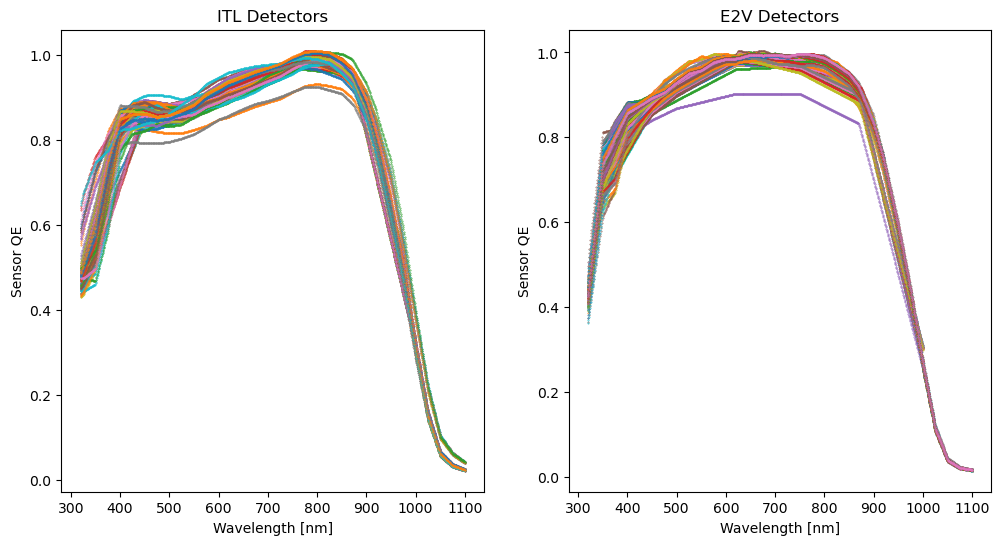

In [12]:
f,ax = plt.subplots(1,2,figsize=(12,6))

sensor_types = ['ITL','E2V']
for i,aptype in enumerate(sensor_types):
    for det in camera:
    
        det_name = det.getName()
        ptype = det.getPhysicalType()
        idet = det.getId()
        det_name = det_names[idet]
        if ptype == aptype:
            lambdas,qe_values = get_qe_lsstcam(idet,camera,butler)
            h = ax[i].scatter(lambdas, qe_values, marker='.',s=0.5)
            ax[i].set_xlabel("Wavelength [nm]")
            ax[i].set_ylabel("Sensor QE")
            ax[i].set_title("%s Detectors"%(aptype))

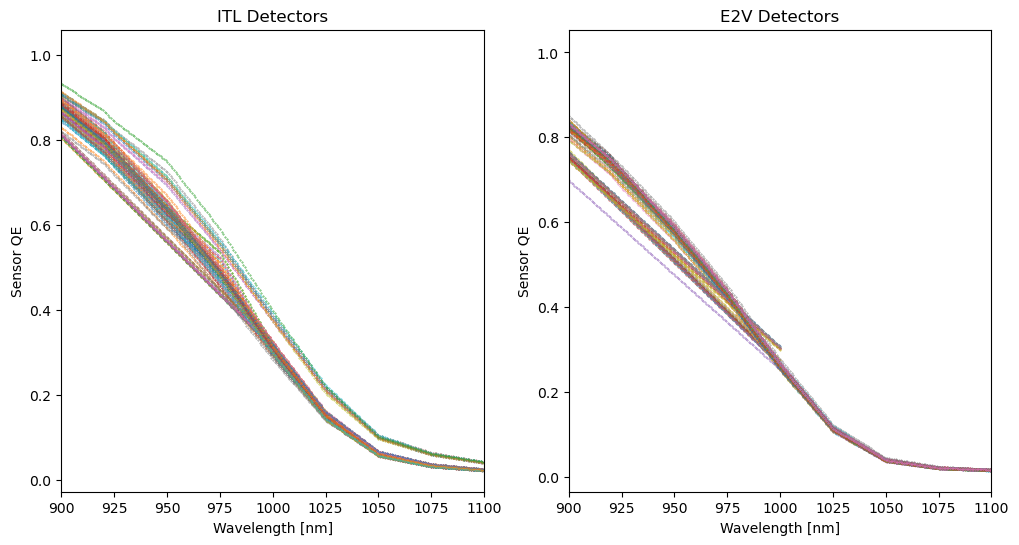

In [13]:
f,ax = plt.subplots(1,2,figsize=(12,6))

sensor_types = ['ITL','E2V']
for i,aptype in enumerate(sensor_types):
    for det in camera:
    
        det_name = det.getName()
        ptype = det.getPhysicalType()
        idet = det.getId()
        det_name = det_names[idet]
        if ptype == aptype:
            lambdas,qe_values = get_qe_lsstcam(idet,camera,butler)
            h = ax[i].scatter(lambdas, qe_values, marker='.',s=0.5)
            ax[i].set_xlim(900.,1100.)
            ax[i].set_xlabel("Wavelength [nm]")
            ax[i].set_ylabel("Sensor QE")
            ax[i].set_title("%s Detectors"%(aptype))

# dump all data to a DF

In [14]:
qedict = {}
idet = []
bayslot = []
waves = []
qes = []

for i,det in enumerate(camera):
    det_name = det.getName()
    det_ptype = det.getPhysicalType()
    if det_ptype=='E2V' or det_ptype=='ITL':
        hdu = fits.open('lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_%s_LSSTCam_calib_curated_19700101T000000Z.fits'%(det_name))
    
        tput_arr = hdu[2].data['throughput']   # returned as a 1 element array
        waves_arr = hdu[2].data['wavelengths']
        
        idet.append(i)
        bayslot.append(det_name)
        waves.append(waves_arr[0]/10.)  # convert from Angstroms to nm
        qes.append(tput_arr[0])
        
qedict['idet'] = idet
qedict['bayslot'] = bayslot
qedict['wave'] = waves
qedict['qe'] = qes

df = pd.DataFrame(qedict)
df.set_index('idet')
            

,bayslot,wave,qe
idet,,,
0,R01_S00,"[319.993994140625, 324.968994140625, 349.98198...","[0.4862901270389557, 0.5068447589874268, 0.610..."
1,R01_S01,"[319.993994140625, 324.968994140625, 349.98198...","[0.43776634335517883, 0.4471161663532257, 0.51..."
2,R01_S02,"[319.993994140625, 324.968994140625, 349.98198...","[0.49374938011169434, 0.5139611959457397, 0.61..."
3,R01_S10,"[319.993994140625, 324.968994140625, 349.98198...","[0.49032485485076904, 0.5122615098953247, 0.62..."
4,R01_S11,"[319.993994140625, 324.968994140625, 349.98198...","[0.502561628818512, 0.5267104506492615, 0.6405..."
...,...,...,...
184,R43_S11,"[319.993994140625, 324.968994140625, 349.98198...","[0.5153786540031433, 0.5383469462394714, 0.653..."
185,R43_S12,"[319.993994140625, 324.968994140625, 349.98198...","[0.5058000087738037, 0.529389500617981, 0.6450..."
186,R43_S20,"[319.993994140625, 324.968994140625, 349.98198...","[0.6472468972206116, 0.6741368174552917, 0.747..."


In [15]:
print(df['qe'][0])
print(df['wave'][0])

[0.48629013 0.50684476 0.61073178 0.74817091 0.84351575 0.8491258
 0.84176338 0.84052342 0.84507531 0.85467321 0.87111092 0.88880551
 0.9103967  0.91944081 0.92287815 0.93779111 0.9497087  0.95698088
 0.96457309 0.97868472 0.99145567 0.99364972 0.98338622 0.96918666
 0.94346273 0.93318003 0.86258531 0.778395   0.75135314 0.62353158
 0.47680819 0.30709928 0.14860593 0.05906795 0.03342243 0.02310501]
[ 319.99399414  324.96899414  349.98198242  374.975       400.01901855
  424.96499023  450.03500977  475.00297852  500.01801758  525.00200195
  550.02900391  575.02299805  599.98198242  619.99702148  624.97900391
  650.01201172  675.00400391  700.0300293   725.01201172  750.02197266
  774.98701172  799.97602539  824.98798828  850.02197266  869.96699219
  875.00205078  899.99902344  919.99902344  925.01201172  949.96503906
  975.00205078  999.97597656 1025.02792969 1050.0140625  1075.00195312
 1099.99003906]


In [16]:
print(df)

     idet  bayslot                                               wave  \
0       0  R01_S00  [319.993994140625, 324.968994140625, 349.98198...   
1       1  R01_S01  [319.993994140625, 324.968994140625, 349.98198...   
2       2  R01_S02  [319.993994140625, 324.968994140625, 349.98198...   
3       3  R01_S10  [319.993994140625, 324.968994140625, 349.98198...   
4       4  R01_S11  [319.993994140625, 324.968994140625, 349.98198...   
..    ...      ...                                                ...   
184   184  R43_S11  [319.993994140625, 324.968994140625, 349.98198...   
185   185  R43_S12  [319.993994140625, 324.968994140625, 349.98198...   
186   186  R43_S20  [319.993994140625, 324.968994140625, 349.98198...   
187   187  R43_S21  [319.993994140625, 324.968994140625, 349.98198...   
188   188  R43_S22  [319.993994140625, 324.968994140625, 349.98198...   

                                                    qe  
0    [0.4862901270389557, 0.5068447589874268, 0.610...  
1    [0.4

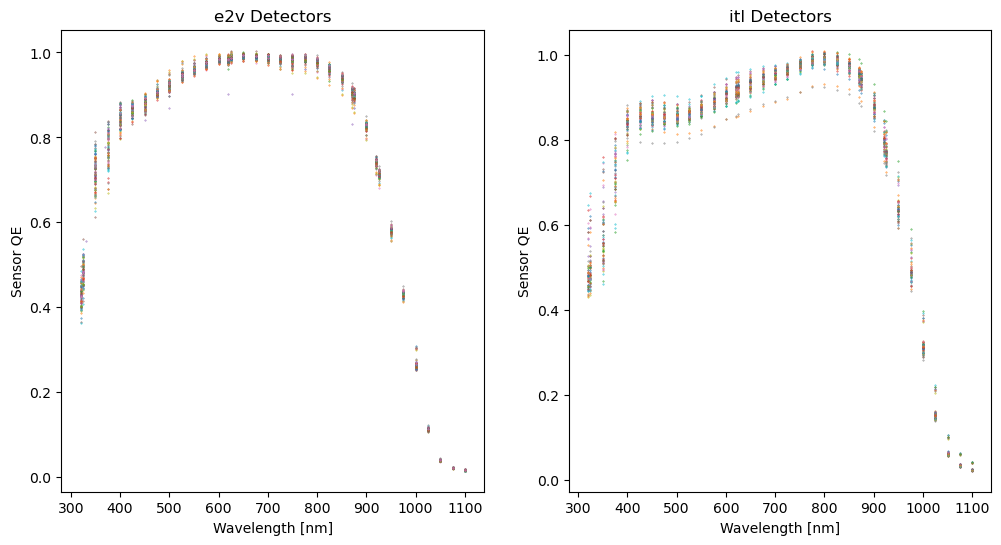

In [17]:
f,ax = plt.subplots(1,2,figsize=(12,6))

types = ['e2v','itl']
for i,atype in enumerate(types):
    for idet in range(205):
    
        det_name = det_names[idet]
        bay = det_name[0:3]
        rtmtype = rtmtypes[bay]
        if rtmtype == atype:
            lambdas = df['wave'][idet]
            qe_values = df['qe'][idet]
            h = ax[i].scatter(lambdas, qe_values, marker='.',s=0.5)

    ax[i].set_xlabel("Wavelength [nm]")
    ax[i].set_ylabel("Sensor QE")
    ax[i].set_title('%s Detectors'%(atype))

In [18]:
df.to_parquet('qe_dm_values.parquet')

# study DE at 1020 and 1050nm